## **Training job skill extraction model**

Installing the required libraries

In [1]:
%pip install contractions
%pip install bert-for-tf2
%pip install tqdm
%pip install tensorflow_hub

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook 

# Upgrade from TF1 to TF2 for bert implementation
# tensorflow_version 2.8.0
import tensorflow as tf
import tensorflow_hub as hub
import bert
from tensorflow import keras
from tensorflow.keras.layers import Input

# Params for bert model and tokenization
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

In [3]:
print(tf.__version__)
print(hub.__version__)

2.7.0
0.12.0


In [4]:
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-03-29 11:03:59.926274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 11:03:59.943630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 11:03:59.943828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


/device:GPU:0


2022-03-29 11:03:59.945527: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-29 11:03:59.945859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 11:03:59.946038: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 11:03:59.946185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

In [5]:
colab_used = False
if colab_used:
    from google.colab import drive
    drive.mount('/content/drive')

###Data Import and Pre-processing

In [6]:
input_path_colab = "/content/drive/MyDrive/SFU/CMPT733/project/processing/"
input_path_lab = "processing/"

input_path = input_path_colab if colab_used else input_path_lab

input_file = "new_consolidated_records1_2022-03-26 173511_labelled.csv"

In [7]:
df1 = pd.read_csv(input_path+input_file, error_bad_lines = True)
#df2 = pd.read_csv(input_path+input_file_invalid, error_bad_lines = True)

#train_data = pd.concat([df1, df2], ignore_index=True)
train_data = df1

train_data.sample(100, random_state = 5)
train_data['text'] = train_data.text.str.strip()
train_data = train_data[train_data.text.str.strip()!='']

/tmp/ipykernel_45401/3750856104.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df1 = pd.read_csv(input_path+input_file, error_bad_lines = True)


In [8]:
train_data.sample(100, random_state = 5)

,Unnamed: 0,text,skill
2951,2903,financial advisor roles,1
5901,5807,progressive hr,1
6377,6280,retention policies,1
3833,3776,innate,0
1147,1125,change,0
...,...,...,...
4424,4363,market insight,1
4813,4747,multiple roles,0
4683,4620,modeling ability,1
5894,5800,programs,1


In [9]:
train_data['skill'].value_counts()

1    5800
0    2143
Name: skill, dtype: int64

In [10]:
# ratio of classes; checking for balance in training data 
print('Number of skill:', train_data['skill'].sum())
print('Number of Not Skill:', len(train_data['skill']) - train_data['skill'].sum())
print('Ratio of classes: Skill=', train_data['skill'].sum() / len(train_data['skill']), ' Not Skill=', 1 - train_data['skill'].sum() / len(train_data['skill']))

Number of skill: 5800
Number of Not Skill: 2143
Ratio of classes: Skill= 0.7302026941961476  Not Skill= 0.2697973058038524


### Model Training

In [11]:
# splitting data 1st iter 85/15 2nd iter 80/20 
# ensuring shuffling due to the sequentual nature of the training set
X = train_data["text"]
y = train_data["skill"]

X_train, X_test, y_train, y_test = train_test_split(
                                                    X, y, 
                                                    test_size = .2,
                                                    random_state = 42,
                                                    shuffle = True
                                                    )

print('{:>5,} training samples'.format(len(X_train)))
print('{:>5,} validation samples'.format(len(X_test)))

6,354 training samples
1,589 validation samples


In [12]:
# According to analysis the largest chunk captured by regex was 18 tokens long
max_seq_length = 18
# data should be np array with new dimension for input 
train_text = X_train[:, np.newaxis]
test_text = X_test[:, np.newaxis]
# always should check and check again
train_text.shape, test_text.shape

/tmp/ipykernel_45401/1553795918.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_text = X_train[:, np.newaxis]
/tmp/ipykernel_45401/1553795918.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  test_text = X_test[:, np.newaxis]


((6354, 1), (1589, 1))

### Tokenization

In [13]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.
  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """
    pass

In [14]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    BertTokenizer = bert.bert_tokenization.FullTokenizer
    bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                                trainable=False)
    vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
    to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
    tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

    return tokenizer

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(str(text)), text_b=None, label=label)
        )
    return InputExamples

In [15]:
# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module()

# Convert data to InputExample format
train_examples = convert_text_to_examples(train_text, y_train)
test_examples = convert_text_to_examples(test_text, y_test)

# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, train_labels 
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=max_seq_length)
(test_input_ids, test_input_masks, test_segment_ids, test_labels
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=max_seq_length)

2022-03-29 11:04:02.818563: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 11:04:02.818779: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 11:04:02.818911: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 11:04:02.819061: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 11:04:02.819165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

Converting examples to features:   0%|          | 0/6354 [00:00<?, ?it/s]

Converting examples to features:   0%|          | 0/1589 [00:00<?, ?it/s]

### Embedding

In [16]:
class BertModel(object):
    
    def __init__(self):
        
        self.max_len = 18
        bert_path = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
        FullTokenizer=bert.bert_tokenization.FullTokenizer
        
        self.bert_module = hub.KerasLayer(bert_path,trainable=True)

        self.vocab_file = self.bert_module.resolved_object.vocab_file.asset_path.numpy()

        self.do_lower_case = self.bert_module.resolved_object.do_lower_case.numpy()

        self.tokenizer = FullTokenizer(self.vocab_file,self.do_lower_case)
        
    def get_masks(self,tokens, max_seq_length):
        return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

    def get_segments(self,tokens, max_seq_length):
        """Segments: 0 for the first sequence, 1 for the second"""
        segments = []
        current_segment_id = 0
        for token in tokens:
            segments.append(current_segment_id)
            if token == "[SEP]":
                current_segment_id = 1
        return segments + [0] * (max_seq_length - len(tokens))
    
    def get_ids(self,tokens, tokenizer, max_seq_length):
        """Token ids from Tokenizer vocab"""
        token_ids = tokenizer.convert_tokens_to_ids(tokens,)
        input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
        return input_ids
    def create_single_input(self,sentence,maxlen):

        stokens = self.tokenizer.tokenize(sentence)

        stokens = stokens[:maxlen]

        stokens = ["[CLS]"] + stokens + ["[SEP]"]

        ids = self.get_ids(stokens, self.tokenizer, self.max_len)
        masks = self.get_masks(stokens, self.max_len)
        segments = self.get_segments(stokens, self.max_len)

        return ids,masks,segments

    def create_input_array(self,sentences):
        
        input_ids, input_masks, input_segments = [], [], []

        for sentence in tqdm_notebook(sentences,position=0, leave=True):
            ids,masks,segments=self.create_single_input(sentence,self.max_len-2)

            input_ids.append(ids)
            input_masks.append(masks)
            input_segments.append(segments)
            
        tensor = [np.asarray(input_ids, dtype=np.int32), 
                np.asarray(input_masks, dtype=np.int32), 
                np.asarray(input_segments, dtype=np.int32)]
        return tensor

In [17]:
class PreprocessingBertData():
    
    def prepare_data_x(self,train_sentences):
        x = bert_model_obj.create_input_array(train_sentences)
        return x
    
    def prepare_data_y(self,train_labels):
        y = list()
        for item in train_labels:
            label = item
            y.append(label)
        y = np.array(y)
        return y

In [18]:
bert_model_obj = BertModel()

### Network Archetecture

In [19]:
class NetworkModel():
    def __init__(self):
        self.model = None        
        self.train_data = [train_input_ids, train_input_masks, train_segment_ids]
        self.train_labels = train_labels
        self.test_data = [test_input_ids, test_input_masks, test_segment_ids]
        self.test_labels = test_labels
        
    def bert_model(self,max_seq_length): 
        in_id = Input(shape=(max_seq_length,), dtype=tf.int32, name="input_ids")
        in_mask = Input(shape=(max_seq_length,), dtype=tf.int32, name="input_masks")
        in_segment = Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")
        
        bert_inputs = [in_id, in_mask, in_segment]

        pooled_output, sequence_output = bert_model_obj.bert_module(bert_inputs)
        """
        #x = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)
        x = tf.keras.layers.SpatialDropout1D(0.2)(sequence_output)
        x = tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2),
        pred = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
        optimizer = tf.keras.optimizers.Adam(lr=0.00001)
        self.model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
        self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        """
        
        x = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        x = tf.keras.layers.Dense(32, activation='relu')(x)
        x = tf.keras.layers.Dense(24, activation='tanh')(x)
        x = tf.keras.layers.Dense(12, activation='relu')(x)
        pred = tf.keras.layers.Dense(1, activation='softplus')(x)
        optimizer = tf.keras.optimizers.Adam(lr=0.00001)
        self.model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
        self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        
        
        
        self.model.summary()
    
    def model_train(self,batch_size,num_epoch):
        print("Fitting to Model")
        
        self.model.fit(self.train_data,self.train_labels,epochs=num_epoch,batch_size=batch_size,validation_split=0.2,shuffle=True)
        
        print("Model Training Complete.")
    
    def model_test(self):
        print("Model Testing on Unseen Data")

        self.model.evaluate(self.test_data, self.test_labels)
        
        print("Model Testing Complete.")

    def save_model(self,model_folder,model_name):    
        self.model.save(model_name+".h5", overwrite=True, include_optimizer=True)
        print("Model saved to Model folder.")

    def get_model(self):    
        return self.model

In [20]:
model_obj = NetworkModel()
model_obj.bert_model(bert_model_obj.max_len)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 18)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 18)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 18)]         0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     [(None, 768),        109482241   ['input_ids[0][0]',              
                                 (None, 18, 768)]                 'input_masks[0][0]',        

/usr/shared/CMPT/big-data/condaenv/gt/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Start Training

In [21]:
# training model 1st iter 25 epochs and was clear that less than 10 epochs were sufficient
# anywhere from 6~8 epochs deliver optimal results; batch size was unchanged, softplus

# training model 2nd iter 8 epochs; still only 60% on unseen
# splitting changed 80/20 batch size was increased tp 50, sigmoid in place of soft plus
#model = build_model(max_seq_length)

model = model_obj

# Instantiate variables
#initialize_vars(sess)

# batch_size = 60
# num_epoch = 6
model.model_train(60, 20)

'''
model.fit(
        [train_input_ids, train_input_masks, train_segment_ids], 
        train_labels,
        validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),
        epochs=6,
        batch_size=60
         )
'''

Fitting to Model
Epoch 1/20
85/85 [==============================] - 20s 142ms/step - loss: 0.5428 - accuracy: 0.7334 - val_loss: 0.5085 - val_accuracy: 0.7467
Epoch 2/20
85/85 [==============================] - 11s 135ms/step - loss: 0.5209 - accuracy: 0.7452 - val_loss: 0.5139 - val_accuracy: 0.7262
Epoch 3/20
85/85 [==============================] - 12s 136ms/step - loss: 0.5097 - accuracy: 0.7602 - val_loss: 0.5039 - val_accuracy: 0.7309
Epoch 4/20
85/85 [==============================] - 12s 137ms/step - loss: 0.4984 - accuracy: 0.7647 - val_loss: 0.5433 - val_accuracy: 0.7325
Epoch 5/20
85/85 [==============================] - 12s 138ms/step - loss: 0.4903 - accuracy: 0.7732 - val_loss: 0.5173 - val_accuracy: 0.7482
Epoch 6/20
85/85 [==============================] - 12s 138ms/step - loss: 0.4554 - accuracy: 0.7909 - val_loss: 0.5045 - val_accuracy: 0.7648
Epoch 7/20
85/85 [==============================] - 12s 138ms/step - loss: 0.4468 - accuracy: 0.7863 - val_loss: 0.6553 - val

'\nmodel.fit(\n        [train_input_ids, train_input_masks, train_segment_ids], \n        train_labels,\n        validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),\n        epochs=6,\n        batch_size=60\n         )\n'

In [22]:
model.save_model(input_path, "job_skill_extraction_bert")

Model saved to Model folder.


## **Model Evaluation**

In [23]:
%pip install pydot
%pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


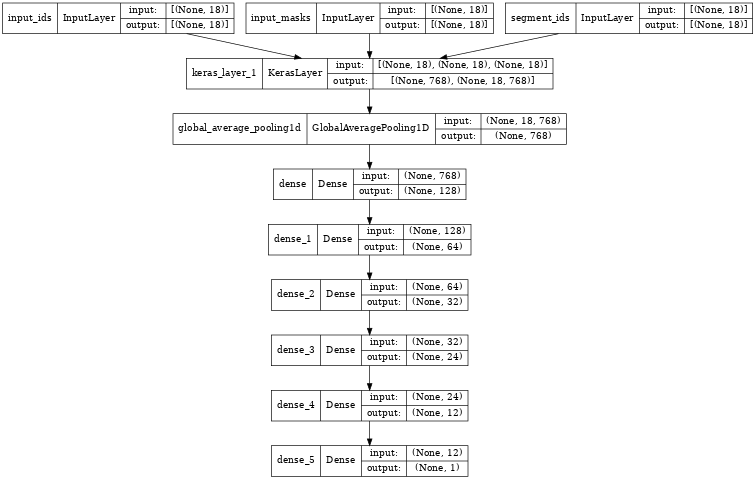

In [24]:
# After many interations to find an optimal structure this is the result
tf.keras.utils.plot_model(model_obj.get_model(), show_shapes=True, dpi=48)


In [25]:
# Accuracy on 1st iter ~85%; Accuracy on 2nd iter +0.5

accr = model_obj.get_model().evaluate([test_input_ids, 
                       test_input_masks, 
                       test_segment_ids], 
                       y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

50/50 [==============================] - 1s 29ms/step - loss: 0.6448 - accuracy: 0.7804
Test set
  Loss: 0.645
  Accuracy: 0.780


In [26]:
# Test on (assuming) unseen data
unseen = np.array([ 
                   'mongodb',
                   'statistics , mathematics , biostatistics',
                   'experience in python', 
                   'language e.g',
                   'this is fucking bullshit', 
                   'the definition', 
                   'hard-worker',
                   'san francisco bay area' ,
                   'many things',
                   'passion for data',
                   ])
unseen_text = unseen[:, np.newaxis]

# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module()

# Convert data to InputExample format
unseen_examples = convert_text_to_examples(unseen_text, np.zeros((10,1)))

# Convert to features
(unseen_input_ids, unseen_input_masks, unseen_segment_ids, unseen_labels 
) = convert_examples_to_features(tokenizer,
                                 unseen_examples,
                                 max_seq_length=max_seq_length)

/tmp/ipykernel_45401/452287323.py:77: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for example in tqdm_notebook(examples, desc="Converting examples to features"):


Converting examples to features:   0%|          | 0/10 [00:00<?, ?it/s]

In [27]:
unseen_truth = np.array([0, 1, 1, 0, 1, 0, 1, 0, 0, 1])
accr = model.get_model().evaluate([unseen_input_ids, 
                       unseen_input_masks, 
                       unseen_segment_ids], 
                       unseen_truth)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1/1 [==============================] - 1s 696ms/step - loss: 2.1683 - accuracy: 0.6000
Test set
  Loss: 2.168
  Accuracy: 0.600


In [28]:
unseen_predictions = model.get_model().predict([unseen_input_ids, 
                                    unseen_input_masks, 
                                    unseen_segment_ids] 
                                    )
unseen_predictions.shape

(10, 1)

In [29]:
predictions = pd.DataFrame(dict(list(zip(unseen, unseen_predictions))))
predictions.T

,0
mongodb,0.442940
"statistics , mathematics , biostatistics",0.903280
experience in python,0.661584
language e.g,0.863715
this is fucking bullshit,0.756523
the definition,0.603612
hard-worker,0.725418
san francisco bay area,1.205204
many things,0.837246
passion for data,1.047685


### Generate More Predictions for Evaluation Analysis

In [30]:
sample_file1 = "sample1.csv"
sample_file2 = "sample2.csv"
predict_data_df1 = pd.read_csv(input_path+sample_file1)
predict_data_df2 = pd.read_csv(input_path+sample_file2)

predict_data1 = predict_data_df1['extractions'].to_numpy()[:, np.newaxis]
predict_data2 = predict_data_df2['extractions'].to_numpy()[:, np.newaxis]

# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module()

# Convert data to InputExample format
predict_text1 = convert_text_to_examples(predict_data1, np.zeros((predict_data_df1.shape[0],1)))
predict_text2 = convert_text_to_examples(predict_data2, np.zeros((predict_data_df2.shape[0],1)))



In [31]:
# Convert to features
(predict1_input_ids, predict1_input_masks, predict1_segment_ids, predict1_labels 
) = convert_examples_to_features(tokenizer,
                                 predict_text1,
                                 max_seq_length=max_seq_length)

prediction1 = model.get_model().predict([predict1_input_ids, 
                                    predict1_input_masks, 
                                    predict1_segment_ids] 
                                    )


predictions = pd.DataFrame(dict(list(zip(predict_data_df1['extractions'].to_numpy(), prediction1))))
predictions.T

/tmp/ipykernel_45401/452287323.py:77: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for example in tqdm_notebook(examples, desc="Converting examples to features"):


Converting examples to features:   0%|          | 0/238 [00:00<?, ?it/s]

,0
the hr data science analyst implements,0.743218
analytics models,1.292091
solutions,0.675158
prescriptive insights,0.830595
data,0.977330
...,...
does,0.302034
discriminate,0.607211
protected,0.380104
"direction , business objectives ,",0.508182


In [32]:
# Convert to features
(predict2_input_ids, predict2_input_masks, predict2_segment_ids, predict2_labels 
) = convert_examples_to_features(tokenizer,
                                 predict_text2,
                                 max_seq_length=max_seq_length)

prediction2 = model.get_model().predict([predict2_input_ids, 
                                    predict2_input_masks, 
                                    predict2_segment_ids] 
                                    )
predictions = pd.DataFrame(dict(list(zip(predict_data_df2['extractions'].to_numpy(), prediction2))))
predictions.T

/tmp/ipykernel_45401/452287323.py:77: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for example in tqdm_notebook(examples, desc="Converting examples to features"):


Converting examples to features:   0%|          | 0/249 [00:00<?, ?it/s]

,0
the sales associate,0.885605
a customer-oriented sales,0.609241
ample experience,0.843302
maintenance agreements,1.287515
refrigeration industry,0.597585
...,...
visit,0.207825
find,0.229271
"service agreements , repairs , equipment",1.384492
"communication , problem solving ,",0.663546


In [33]:
predict_data_df1['prediction_prob'] = prediction1.reshape(-1)
predict_data_df2['prediction_prob'] = prediction2.reshape(-1)

predict_data_df1.to_csv(input_path+"predictions1.csv")
predict_data_df2.to_csv(input_path+"predictions2.csv")